In [2]:
pip install gluoncv

     |████████████████████████████████| 1.3 MB 4.2 MB/s 


In [3]:
pip install -U mxnet-cu101mkl==1.6.0.post0

     |████████████████████████████████| 712.3 MB 352 bytes/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [4]:
! nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [5]:
pip install pandas

In [6]:
%matplotlib inline

1. Predict with pre-trained Mask RCNN models
===============================================

This article shows how to play with pre-trained Mask RCNN model.

Mask RCNN networks are extensions to Faster RCNN networks.
:py:class:`gluoncv.model_zoo.MaskRCNN` is inherited from
:py:class:`gluoncv.model_zoo.FasterRCNN`.
It is highly recommended to read :doc:`../examples_detection/demo_faster_rcnn` first.

First let's import some necessary libraries:


In [7]:
from matplotlib import pyplot as plt
from gluoncv import model_zoo, data, utils
import mxnet as mx


/usr/local/lib/python3.7/dist-packages/gluoncv/__init__.py:40: UserWarning: Both `mxnet==1.6.0` and `torch==1.10.0+cu111` are installed. You might encounter increased GPU memory footprint if both framework are used at the same time.
  warnings.warn(f'Both `mxnet=={mx.__version__}` and `torch=={torch.__version__}` are installed. '


Load a pretrained model
-------------------------

Let's get an Mask RCNN model trained on COCO dataset with ResNet-50 backbone.
By specifying ``pretrained=True``, it will automatically download the model
from the model zoo if necessary. For more pretrained models, please refer to
:doc:`../../model_zoo/index`.

The returned model is a HybridBlock :py:class:`gluoncv.model_zoo.MaskRCNN`
with a default context of `cpu(0)`.



In [8]:
# using GPU
ctx = mx.gpu(0)
net = model_zoo.get_model('mask_rcnn_resnet50_v1b_coco', pretrained=True,ctx = mx.gpu(0))

print(type(ctx))

100%|██████████| 131497/131497 [00:04<00:00, 28232.09KB/s]


<class 'mxnet.context.Context'>


In [9]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

Pre-process an image
--------------------

The pre-processing step is identical to Faster RCNN.

Next we download an image, and pre-process with preset data transforms.
The default behavior is to resize the short edge of the image to 600px.
But you can feed an arbitrarily sized image.

You can provide a list of image file names, such as ``[im_fname1, im_fname2,
...]`` to :py:func:`gluoncv.data.transforms.presets.rcnn.load_test` if you
want to load multiple image together.

This function returns two results. The first is a NDArray with shape
`(batch_size, RGB_channels, height, width)`. It can be fed into the
model directly. The second one contains the images in numpy format to
easy to be plotted. Since we only loaded a single image, the first dimension
of `x` is 1.

Please beware that `orig_img` is resized to short edge 600px.



# for one picture

In [10]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


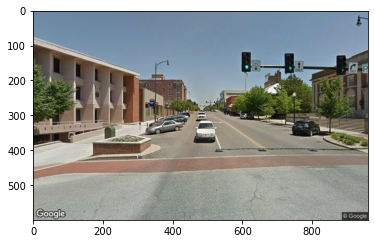

In [11]:
from mxnet import image
from mxnet.gluon.data.vision import transforms
import gluoncv


# Image path
#path = 'originSVI/'

path = '/content/drive/MyDrive/MIZZOU/CAADRIA2022/Paper2/DownloadedSVIs/DownloadedSVIs_Angle_Per1/'
file_name = '1.jpg'
#/content/drive/MyDrive/Caadria/Caadria_Shared/finalflickr/botanic_day/Brisb-botanic-gardens-day_0000.png
x, orig_img = data.transforms.presets.rcnn.load_test(path+file_name)

plt.imshow(orig_img)
plt.show()


Inference and display
---------------------

The Mask RCNN model returns predicted class IDs, confidence scores,
bounding boxes coordinates and segmentation masks.
Their shape are (batch_size, num_bboxes, 1), (batch_size, num_bboxes, 1)
(batch_size, num_bboxes, 4), and (batch_size, num_bboxes, mask_size, mask_size)
respectively. For the model used in this tutorial, mask_size is 14.

Object Detection results

We can use :py:func:`gluoncv.utils.viz.plot_bbox` to visualize the
results. We slice the results for the first image and feed them into `plot_bbox`:

Plot Segmentation

:py:func:`gluoncv.utils.viz.expand_mask` will resize the segmentation mask
and fill the bounding box size in the original image.
:py:func:`gluoncv.utils.viz.plot_mask` will modify an image to
overlay segmentation masks.



runtime: 0:00:56.387630


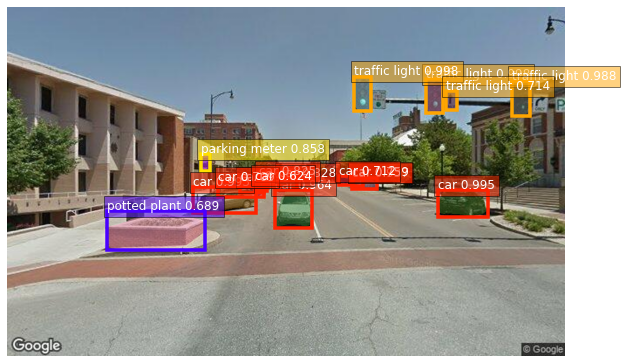

In [12]:
# *************Start Timer***
from datetime import datetime
startTime = datetime.now() # initiate timer

# Get MaskRcnn Results

ids, scores, bboxes, masks = [xx[0].asnumpy() for xx in net(x.as_in_context(mx.gpu(0)))]


# paint segmentation mask on images directly
width, height = orig_img.shape[1], orig_img.shape[0]
masks, _ = utils.viz.expand_mask(masks, bboxes, (width, height), scores)
orig_img = utils.viz.plot_mask(orig_img, masks)

# identical to Faster RCNN object detection
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax = utils.viz.plot_bbox(orig_img, bboxes, scores, ids,
                         class_names=net.classes, ax=ax)
plt.axis('off')

# *************Stop Timer***
print("runtime:",datetime.now()-startTime) # stop timer

plt.show()


In [13]:
print(net.classes)
print(ids[0:10])

['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
[[ 9.]
 [ 9.]
 [ 2.]
 [ 2.]
 [ 9.]
 [ 2.]
 [ 2.]
 [ 2.]
 [12.]
 [ 2.]]


In [14]:
## explanation to "dictionary"

Dict_A={"A":10,"B":[1,3,5],"C":"Your Name"}
Dict_A.keys()
Dict_A.values()

print(Dict_A.keys())
print(Dict_A.values())
print(Dict_A['A'])



dict_keys(['A', 'B', 'C'])
dict_values([10, [1, 3, 5], 'Your Name'])
10


In [ ]:
## Use dictionary to count all the matrixs

In [15]:
import pandas as pd

Count={}
for i in range(len(net.classes)):
    # create a class id list
    className = net.classes[i]
    Count[className] = 0

for j in range(len(ids)):
    classID=int(ids[j])
    classscore=scores[j]
    if classscore>0.5:
        if classID>0:
            className=net.classes[classID]
            Count[className] +=1
            print(className,classscore)
  
df_Count = pd.DataFrame(Count.items(), columns=['class', 'number'])
df_Count = df_Count.T
df_Count['FID'] = file_name.split(".")[0]
print(Count)
df_Count.head(5)

traffic light [0.99806195]
traffic light [0.9980502]
car [0.9947548]
car [0.99316955]
traffic light [0.98771137]
car [0.96404207]
car [0.93725944]
car [0.90352404]
parking meter [0.8577227]
car [0.8275803]
car [0.82522744]
car [0.75880444]
traffic light [0.71435755]
car [0.7117842]
car [0.70915693]
potted plant [0.68892914]
car [0.6244358]
{'person': 0, 'bicycle': 0, 'car': 11, 'motorcycle': 0, 'airplane': 0, 'bus': 0, 'train': 0, 'truck': 0, 'boat': 0, 'traffic light': 4, 'fire hydrant': 0, 'stop sign': 0, 'parking meter': 1, 'bench': 0, 'bird': 0, 'cat': 0, 'dog': 0, 'horse': 0, 'sheep': 0, 'cow': 0, 'elephant': 0, 'bear': 0, 'zebra': 0, 'giraffe': 0, 'backpack': 0, 'umbrella': 0, 'handbag': 0, 'tie': 0, 'suitcase': 0, 'frisbee': 0, 'skis': 0, 'snowboard': 0, 'sports ball': 0, 'kite': 0, 'baseball bat': 0, 'baseball glove': 0, 'skateboard': 0, 'surfboard': 0, 'tennis racket': 0, 'bottle': 0, 'wine glass': 0, 'cup': 0, 'fork': 0, 'knife': 0, 'spoon': 0, 'bowl': 0, 'banana': 0, 'apple'

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,FID
class,person,bicycle,car,motorcycle,airplane,bus,train,truck,boat,traffic light,fire hydrant,stop sign,parking meter,bench,bird,cat,dog,horse,sheep,cow,elephant,bear,zebra,giraffe,backpack,umbrella,handbag,tie,suitcase,frisbee,skis,snowboard,sports ball,kite,baseball bat,baseball glove,skateboard,surfboard,tennis racket,bottle,...,cup,fork,knife,spoon,bowl,banana,apple,sandwich,orange,broccoli,carrot,hot dog,pizza,donut,cake,chair,couch,potted plant,bed,dining table,toilet,tv,laptop,mouse,remote,keyboard,cell phone,microwave,oven,toaster,sink,refrigerator,book,clock,vase,scissors,teddy bear,hair drier,toothbrush,1
number,0,0,11,0,0,0,0,0,0,4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


# Automated Process for multiple images

This part will automate the process of loading images in input folder, doing instance segmentations, saving a summary result csv, and saving output images with masks)

In [18]:
from os import listdir
from os.path import isfile, join
import pandas as pd
import os

path_in= '/content/drive/MyDrive/MIZZOU/CAADRIA2022/Paper2/DownloadedSVIs/DownloadedSVIs_Angle_Per2/'
path_out ='/content/drive/MyDrive/MIZZOU/CAADRIA2022/Paper2/Output_MaskRcNN/Output_MaskRcNN_Angle_Per2/'
all_files = [f for f in listdir(path_in)]
### Get only text files
#jpg_files = list(filter(lambda x: x[-5:] == ('.png') or x[-4:] == ('.png'), all_files))
jpg_files = list(filter(lambda x: x[-5:] == ('.jpeg') or x[-4:] == ('.jpg'), all_files))
jpg_files.sort()
#print(jpg_files) 
print("1.Total Image Files in the folder:",len(jpg_files))

1.Total Image Files in the folder: 332


In [ ]:
# # net.classes includes all the class name in the pre training model
# mcnn_count={}
# for i in range(len(net.classes)):
#     className = net.classes[i]
#     mcnn_count[className] = 0
# print(mcnn_count)

In [19]:
import pandas as pd
import numpy as np
import time
import matplotlib
### build a empty DataFrame
df_mrcnn=pd.DataFrame()
### here is what you want to count
keywords=['person','bicycle','car','motorcycle','bus','truck','boat','traffic light','dog','dining table']

#path = '/content/sample_data/originSVI/'

ID=0
# Load images in the folder
for filename in jpg_files:
    
    fileID=filename.split('.')[0]
    # 1.0 Writedown photo ID to the result dataframe
    df_mrcnn.loc[ID,'Fid']=fileID
    # 1.1 Load an image from the images folder
    # *************Start Timer***
    startTime = time.time() # initiate timer
    x, orig_img = data.transforms.presets.rcnn.load_test(path_in+filename)

    # 2.MaskRcnn Results
    ids, scores, bboxes, masks = [xx[0].asnumpy() for xx in net(x.as_in_context(mx.gpu(0)))]

    # 3.paint segmentation mask on images directly
    width, height = orig_img.shape[1], orig_img.shape[0]
    masks, _ = utils.viz.expand_mask(masks, bboxes, (width, height), scores)
    orig_img = utils.viz.plot_mask(orig_img, masks)

    # 4.identical to Faster RCNN object detection
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax = utils.viz.plot_bbox(orig_img, bboxes, scores, ids,
                             class_names=net.classes, ax=ax)
    plt.axis('off')

    # 5.Save the segmentation result to a csv in the folder
    # 5.1 Select the score
    selected=ids[np.where(scores>0.2)]
    #print("filtered:",selected)
    unique, counts = np.unique(selected, return_counts=True)
    #print(unique,counts)
    # 5.2 count difference class
    for i in range(len(unique)):
        cls_id=int(unique[i])
        cls_name=net.classes[cls_id]
        # print(i,cls_id,cls_name,counts[i])
        if cls_name in keywords:
            #print('in keywords',i,cls_id,cls_name,counts[i])
            df_mrcnn.loc[ID,cls_name]=counts[i]
            df_mrcnn.to_csv(path_out+'mrcnn_result_Angle_Per2.csv', index=False, encoding='utf-8')
    ID+=1
    
    df_mrcnn.to_csv(path_out+'mrcnn_result_Angle_Per2.csv', index=False, encoding='utf-8')
    plt.savefig(path_out+ fileID+'.png', bbox_inches='tight')
    #plt.show()
    plt.close()
    
        # *************Stop Timer***
    endTime = time.time()
    print('Processing', filename, 'ID:', fileID,"runtime:",endTime-startTime)
print("All Done")
df_mrcnn.head(5)
    


Processing 1.jpg ID: 1 runtime: 4.5051350593566895
Processing 10.jpg ID: 10 runtime: 3.630547285079956
Processing 100.jpg ID: 100 runtime: 3.7237589359283447
Processing 101.jpg ID: 101 runtime: 3.5561587810516357
Processing 102.jpg ID: 102 runtime: 3.423738718032837
Processing 103.jpg ID: 103 runtime: 3.5169811248779297
Processing 104.jpg ID: 104 runtime: 3.5058584213256836
Processing 105.jpg ID: 105 runtime: 3.6694607734680176
Processing 106.jpg ID: 106 runtime: 3.5300710201263428
Processing 107.jpg ID: 107 runtime: 3.5422661304473877
Processing 108.jpg ID: 108 runtime: 3.5286736488342285
Processing 109.jpg ID: 109 runtime: 3.781794548034668
Processing 11.jpg ID: 11 runtime: 3.523883819580078
Processing 110.jpg ID: 110 runtime: 3.710878610610962
Processing 111.jpg ID: 111 runtime: 3.5051488876342773
Processing 112.jpg ID: 112 runtime: 3.4247636795043945
Processing 113.jpg ID: 113 runtime: 3.614102602005005
Processing 117.jpg ID: 117 runtime: 3.7736291885375977
Processing 118.jpg ID: 1

,Fid,person,car,truck,traffic light,bicycle,boat,bus,motorcycle,dining table
0,1,1.0,31.0,1.0,5.0,NaN,NaN,NaN,NaN,NaN
1,10,NaN,7.0,2.0,8.0,NaN,NaN,NaN,NaN,NaN
2,100,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,101,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']